# Linearna regresija

U ovom primeru ćemo primeniti model linearne regresije nad realnim podacima. Potrebno je da odredimo model kojim se predviđa cena nekretnina koristeći poznati skup [Boston housing](http://archive.ics.uci.edu/ml/datasets/Housing). 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing

## Učitavanje i analiza skupa podataka  

Podatke možemo učitati koristeći `load_boston` funkciju paketa `datasets`.

In [2]:
data = datasets.load_boston()

Više o samom skupu podataka možemo pročitati u opisu `DESCR` učitanog skupa.

In [3]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Kao što možemo primetiti, skup raspolaže sa 13 različitih atributa koji su numeričkog tipa. Njihova imena možemo izdvojiti pomoću svojstva `feature_names`.

In [4]:
data.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
number_of_features = len(data.feature_names)

In [6]:
number_of_features

13

Same podatke možemo pročitati korišćenjem `data` svojstva. U pitanju je 506 instanci. 

In [7]:
X = data.data

In [8]:
X.shape

(506, 13)

Vrednosti ciljne promenljive se mogu pročitati preko svojstva `target`.

In [9]:
y = data.target

In [10]:
y.shape

(506,)

Pre nego li se upustimo u modelovanje, ispitaćemo vrednosti atributa i njihove skale. Ova ispitivanja može olakšati prelazak na Pandas strukture podataka. Kolonama matrice podataka ćemo pridružiti imena atributa, a koloni koja sadrži vrednosti ciljne promenljive 'MEDV' ime. 

In [11]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["MEDV"])

Inofrmacije o skupu sa kojim radimo, imena atributa i njihove tipove, kao i brz uvid u prisustvo nedostajućih vrednosti će nam dati `info` funkcija.

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Funkcijom `describe` se može dobiti deskriptivna statistika skupa kao što su srednja vrednost atributa, njihova standardna devijacija, minimalna i maksimalna vrednost u skupu, 25%, 50% i 75% percentil vrednosti. 

In [13]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Brz grafički uvid u vrednosti pojedinačnih atributa i njihove distribucije nam daje funkcija `hist`.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a202caf90>,
      dtype=object)

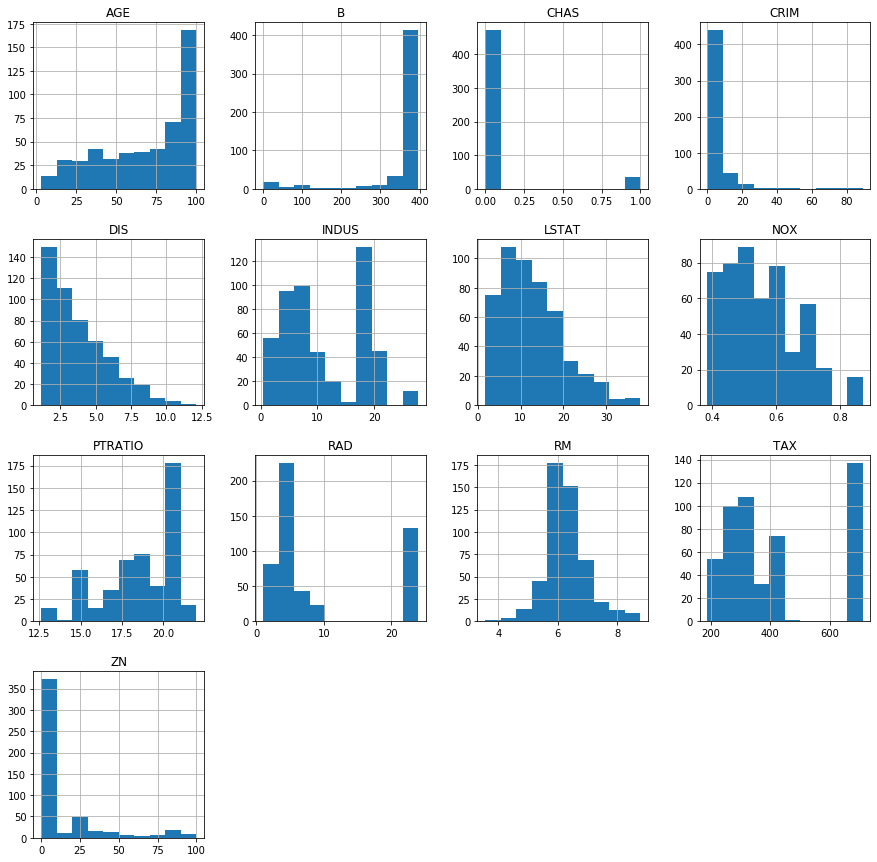

In [14]:
X.hist(figsize = [15,15])

Informacije o međusobnim zavisnostima atributa možemo dobiti pozivom funkcije `corr` koja izračunava Pirsonov koeficijent korelacije.

In [15]:
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


Podatke ćemo pripremiti podelom na skup za treniranje i skup za testiranje u razmeri 2:1. Vrednost `random_state` parametra ćemo postaviti nasumično na vrednost 7.

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7)

Kako se podaci sa kojima radimo odnose na različite fizičke veličine sa vrednostima koje su na različitim skalama, pre učenja modela ćemo se pozabatiti standardizacijom podataka. Standardizacija podrazumevanje centriranje vrednosti pojedinačnih atributa oko nule i njihovo skaliranje na jediničnu varijansu. Kod pod komentarima ukazuje na pojedinačne korake ovog procesa, a kako je ovo čest zadatak, koristićemo ugrađenu klasu `StandardScaler` koja automatizuje zadatke. Pozivom metode `fit` izračunavaju se potrebne statistike, a pozivom metode `transform` vrši se transformacija skupa na opisani način. Važno je napomenuti da se statistike izračunavaju na **skupu za treniranje**, a potom koriste za transformaciju i skupa za treniranje i skupa za testiranje. Sveska posvećena standardizaciji će dati više uvida i opravdati izbor ovakvih procedura. 

In [17]:
# X_means = np.mean(X_train, axis=0)
# X_std = np.std(X_train, axis=0)
# X_train = (X_train-X_means)/X_std
# X_test = (X_test-X_means)/X_std

In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Učenje modela

Model ćemo kreirati pozivom funkcije `LinearRegression` i dalje trenirati pozivom funkcije `fit` nad skupom za treniranje.

In [19]:
model = linear_model.LinearRegression()

In [20]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Vrednosti izračunatih koeficijenata ćemo ispisati prolaskom kroz niz `coef_`. 

In [21]:
for feature, coef in zip(data.feature_names, model.coef_.ravel()):
    print (feature, coef)

CRIM -0.7912984250357167
ZN 0.593755121784215
INDUS 0.06452405315141148
CHAS 0.6770496739495432
NOX -1.7735716984784249
RM 3.8700416325737277
AGE -0.39432929438845304
DIS -2.7405608088072064
RAD 2.2919496264644144
TAX -1.8743793117587249
PTRATIO -2.113902029429804
B 0.8270159811724077
LSTAT -2.8331502177297176


Vrednost slobodnog člana možemo dobiti očitavanjem `intercept_` svojstva.

In [22]:
model.intercept_

array([22.64306785])

Iz razloga što su atributi na istim skalama, lakše možemo protumačiti i interpretirati vrednosti dobijenih koeficijenata. Možemo primetiti da atrubuti RM, DIS, RAD, TAX, PTRATIO, LSTAT, neki pozitivno, a neki negativno uticu u velikoj meri da vrednost ciljne promenljive. Ovim pitanjem ćemo se još detaljno baviti u svesci koja se tiče selekcije atributa.

## Evaluacija modela

Model ćemo evaluirati u terminima koeficijenta determinacije i srednjekvadratne greške na **skupu za testiranje**.

In [23]:
y_predicted = model.predict(X_test)

In [24]:
metrics.mean_squared_error(y_predicted, y_test)

25.322307423586217

In [25]:
metrics.r2_score(y_predicted, y_test)

0.5844375463291132

## Čuvanje modela

Čuvanje modela podrazumeva čuvanje dobijenih koeficijenata, kao i konfiguracije samog modela. Pakete `pickle` i `joblib` možemo upotrebiti u ove svrhe. Oba paketa raspolažu metodama `dump` i `load` kojim se čuvaju tj. učitavaju parametri modela.

In [26]:
import pickle

In [27]:
model_filename = 'models/boston_houses.model'

In [28]:
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

Uz čuvanje modela potrebno je sačuvati i scaler koji smo koristili za pripremu podataka. 

In [29]:
scaler_filename = 'models/boston_houses.scaler'

In [30]:
with open(scaler_filename, 'wb') as pickle_file:
    pickle.dump(scaler, pickle_file)

## Rekreiranje modela i ponovno korišćenje

Za učitavanje modela koristimo funkciju `load`.

In [31]:
with open(model_filename, 'rb') as pickle_file:
    model_revived = pickle.load(pickle_file)

In [32]:
with open(scaler_filename, 'rb') as pickle_file:
    scaler_revived = pickle.load(pickle_file)

Za novu instancu prilikom predviđanja vrednosti prvo pripremamo instancu, a potom i pozivamo model.

In [33]:
new_instance = np.random.randn(number_of_features)

In [34]:
new_instance_scaled = scaler_revived.transform(new_instance.reshape(1, -1))

In [35]:
new_value = model_revived.predict(new_instance_scaled)

In [36]:
new_value

array([[34.66199382]])